<a href="https://colab.research.google.com/github/tnwlvos/machinelearning2/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Transformer_model.py
(Attention is all you need 논문 기반)

- Transformer model 구성 요소:
    1) Encoder:
        - Linear Projection + Positional Encoding
        - Encoder Layer (N개 반복)
            - Multi-Head Self Attention (residual + LayerNorm 포함)
            - FFN (residual + LayerNorm 포함)
    2) Decoder:
        - Linear Projection + Positional Encoding
        - Decoder Layer (N개 반복)
            - Masked MHSA (residual + LayerNorm 포함)
            - Encoder-Decoder MHA (residual + LayerNorm 포함)
            - FFN (residual + LayerNorm 포함)
    3) Output Projection:

- CustomSchedule

전체 코드 출처:
    https://wikidocs.net/31379 (블로그)
    https://github.com/ukairia777/tensorflow-transformer (github)

"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K   # ★ 추가
from sklearn.preprocessing import StandardScaler
# ------------------------------------------------
# Positonal Encoding Layer 정의 (class)
# Scaled Dot Product Attention 함수 정의 (function)
# Multi Head Attention Layer 정의 (class)
# ------------------------------------------------

class PositionalEncoding(tf.keras.layers.Layer):
    """ Positional Encoding Layer (Sinusodal)

    입력 토큰의 순서 정보를 모델에 제공하기 위해
    사인/코사인 기반의 positional embedding을 생성하여 입력 텐서에 더하기.
    """
    def __init__(self, position, d_model):
        """
        Args:
            position (int): 문장 최대 길이
            d_model (int): 임베딩 차원
        """
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        """
        각 위치(position)와 차원 index(i)에 대해
        1 / (10000^(2i/d_model)) 형태의 비율을 계산한다.

        Args:
            position (tf.Tensor): 위치 index (shape: (pos, 1))
            i (tf.Tensor): 차원 index (shape (1, d_model))
            d_model (int): 임베딩 차원.

        Returns:
            angle_rads (shape: (position, d_model))
        """

        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        """ Sinusodial Positional Encoding 텐서 생성

        Args:
            position (int): 문장 최대 길이
            d_model (int): 임베딩 차원

        Returns:
            tf.Tensor: shape(1, position, d_model)
                짝수 index는 sin, 홀수 index는 cos 값을 갖는 encoding.

        """
        angle_rads = self.get_angles(
            #tensor라는 자료형으로 position과 i값을 정해줌 (:,1), (1,:)형태로 변환도 동시에 함
                position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                d_model=d_model)

        # 짝수 index
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 홀수 index
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        # print(pos_encoding.shape)

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        """ 입력 + positional encoding이 더해진 결과를 반환 """
        if K.is_sparse(inputs):
          inputs = K.to_dense(inputs)

        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



In [2]:


def scaled_dot_product_attention(query, key, value, mask):
    """ Scaled Dot Product Attention Function

    Q·K^T 연산 후 sqrt(d_k)로 스케일링하고,
    필요 시 masking을 적용한 뒤 softmax를 통해 attention weight를 계산
    해당 weight를 V에 곱해 최종 attention 출력을 생성

    Args:
        query (tf.Tensor): Query 행렬
            shape: (batch_size, num_heads, query의 문장 길이, d_k)
        key(tf.Tensor): Key 행렬
            shape: (batch_size, num_heads, key의 문장 길이, d_k)
        value (tf.Tensor): Value 행렬
            shape: (batch_size, num_heads, value의 문장 길이, d_k)

        mask (tf.Tensor or None):
            padding 또는 look-ahead 위해 매우 작은 음수를 부여하기 위한 mask 텐서
            shape: (batch_size, num_heads, key의 문장 길이, d_k)

    Returns:
        tuple:
            output (tf.Tensor): attention weight를 Value에 적용한 결과
                shape: (batch_size, num_heads, query의 문장 길이, d_k)
            attention_weights (tf.Tensor): softmax로 정규화된 attention 분포
                shape: (batch_size, num_heads, query의 문장 길이, key의 문장 길이)

    """
    # Q와 K의 곱. 어텐션 스코어 행렬.(Key에는 트랜스포즈를 걸어주고 계산)
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링: d_k(= d_model/num_heads)의 루트 값으로 나눠준다. cast는 형변환
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(d_k)

    # masking 적용 시 매우 작은 음수가 softmax 통과 후 0에 수렴
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights



In [3]:


class MultiHeadAttention(tf.keras.layers.Layer):
    """ Multi Head Attention Layer

    입력(query, key, value)에 대해 W_Q, W_K, W_V를 적용한 뒤
    head 수(num_heads) 만큼 분리하여 병렬로 Scaled Dot Product Attention을 수행,
    다시 concatenate 후 W_O를 통과시켜 최종 출력을 반환

    Attributes:
        d_model (int): 임베딩 차원.
        num_heads (int): 병렬 attention head 개수.
        d_k (int): 각 head가 갖는 깊이(depth = d_model / num_heads).
        query_dense (tf.keras.layers.Dense): W_Q 선형 변환.
        key_dense (tf.keras.layers.Dense): W_K 선형 변환.
        value_dense (tf.keras.layers.Dense): W_V 선형 변환.
        dense (tf.keras.layers.Dense): W_O 선형 변환.
    """

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        # 임베딩 차원은 head 차원 수로 나눠 떨어져야 함 (논문 조건)
        assert d_model % self.num_heads == 0
        self.d_k = d_model // self.num_heads

        # WQ, WK, WV, WO에 해당하는 Dense Layer 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.out_dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        """ num_heads 개수만큼 Q, K, V의 d_model을 split하는 함수 """
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.d_k))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        """ MHA 적용

        Args:
            inputs (dict):
                {
                    'query': (batch_size, query 문장 길이, d_model),
                    'key': (batch_size, key 문장 길이, d_model),
                    'value': (batch_size, value 문장 길이, d_model),
                    'mask': (batch_size, 1, 1, key 문장 길이) or None
                }

        Returns:
            tf.Tensor: MHA 결과를 W_O로 투영한 최종 출력
                shape: (batch_size, query 문장 길이, d_model)

        """
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. Q, K, V 선형 변환 (Dense Layer 통과)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. heads 나누기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. Scaled Dot Product Attention 수행
        # output shape: (batch_size, num_heads, query의 문장 길이, d_k)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # Transpose -> (batch_size, query의 문장 길이, num_heads, d_k)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # 5. 출력 선형 변환 (Dense Layer 통과)
        outputs = self.out_dense(concat_attention)

        return outputs


In [4]:

def create_padding_mask(x):
    """ padding 토큰 masking 용 함수 (padding은 Attention 연산에서 제외) """
    if len(x.shape) == 3:
        # x = tf.squeeze(x, axis=-1)
        x = x[..., 0] #axis=-1 squeeze 대신 첫 채널만 사용
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    mask = mask[:, tf.newaxis, tf.newaxis, :]

    # ★ SparseTensor 방지
    return tf.convert_to_tensor(mask)



In [5]:


def create_look_ahead_mask(x):
    """ Decoder의 Self Attention에서 미래 Token을 참조하지 못하도록 막기 위한 mask

    아직 생성되지 않은 미래 위치를 보지 않기 위함
    padding_mask 기능 포함
    """
    """
    x: (batch, seq_len, 1)
    반환: (batch, 1, seq_len, seq_len)
    """
    seq_len = tf.shape(x)[1]
    batch_size = tf.shape(x)[0]

    # (seq_len, seq_len)
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

    # (1, 1, seq_len, seq_len)
    mask = tf.reshape(mask, (1, 1, seq_len, seq_len))

    # (batch, 1, seq_len, seq_len) 로 배치 차원만큼 복제
    mask = tf.tile(mask, [batch_size, 1, 1, 1])

    return tf.convert_to_tensor(mask)



In [6]:


# ------------------------------------------------
# Encoder Layer 정의
# Encoder block 정의
# ------------------------------------------------

def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    """ Encoder Layer

    Transformer의 Encoder 1개 층(layer) 구성
      1) Multi-Head Self Attention + Residual(잔차) + LayerNorm
      2) Feed Forward Network (FFN, activation: relu) + Residual(잔차) + LayerNorm

    Args:
        dff (int): FFN 내부의 hidden dimension.
        d_model (int): 임베딩 차원 (attention output dimension).
        num_heads (int): Multi-head attention head 개수.
        dropout (float): dropout 비율.

    Returns:
        tf.keras.Model:
            입력:
                inputs (batch, seq_len, d_model)
                padding mask (batch, 1, 1, seq_len)
            출력:
                (batch, seq_len, d_model)
    """

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1) MHA 셀프 어텐션 (Q=K=V=inputs)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
               'query': inputs,
               'key': inputs,
               'value': inputs, # Q = K = V
               'mask': padding_mask # 패딩 마스크 사용
               })

    # Dropout + residual 연결과 LayerNorm 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 2) FFN (activation: relu)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # Dropout + residual 연결과 LayerNorm 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
            inputs=[inputs, padding_mask],
            outputs=outputs, name=name
            )



In [7]:


def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
    """ Transformer Encoder block 전체 구성

    Token 입력 - Linear Projection - scale 조정 - Positional Encoding
    -> Encoder Layer N개 반복 후 최종 인코더 출력 생성

    Args:
        vocab_size (int): 단어 집합 크기. --> 현재 코드는 시계열 주가 예측을 위한 것으로  1로 고정
        num_layers (int): Encoder layer 반복 횟수.
        dff (int): Feed Forward Network 내부 차원.
        d_model (int): 임베딩 차원.
        num_heads (int): multi-head attention head 수.
        dropout (float): dropout 비율.

    Returns:
        tf.keras.Model:
            입력:
                inputs (batch, seq_len, d_model)
                padding mask (batch, 1, 1, seq_len)
            출력:
                (batch, seq_len, d_model)
    """

    # 시계열 numerical input
    #수정
    inputs = tf.keras.Input(shape=(None, 2), name="inputs", dtype=tf.float32, sparse=False)

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Embedding 제거 → Linear Projection 적용
    x = tf.keras.layers.Dense(d_model)(inputs)

    # scale 조정
    x *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Positional Encoding 적용
    x = PositionalEncoding(5000, d_model)(x)

    x = tf.keras.layers.Dropout(dropout)(x)

    # Encoder Layer N개 반복 (N: num_layers)
    for i in range(num_layers):
        x = encoder_layer(dff, d_model, num_heads, dropout,
                          name=f"encoder_layer_{i}")([x, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=x, name=name)





In [8]:

# ------------------------------------------------
# Decoder Layer 정의
# Decoder block 정의
# ------------------------------------------------


def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    """ Decoder Layer

    Transformer의 Decoder 1개 층(layer) 구성
      1) Masked Multi-Head Self Attention (look-ahead + padding mask) + Residual(잔차) + LayerNorm
      2) Encoder–Decoder Multi-Head Attention (padding mask) + Residual(잔차) + LayerNorm
      3) Feed Forward Network (FFN, activation: relu) + Residual(잔차) + LayerNorm

    Args:
        dff (int): FFN 내부의 hidden dimension.
        d_model (int): 임베딩 차원.
        num_heads (int): multi-head attention head 개수.
        dropout (float): dropout 비율.

    Returns:
        tf.keras.Model:
            입력:
                inputs (batch, tgt_seq_len, d_model)
                encoder_outputs (batch, src_seq_len, d_model)
                look_ahead_mask (batch, 1, tgt_seq_len, tgt_seq_len)
                padding_mask (batch, 1, 1, src_seq_len)
            출력:
                (batch, seq_len, d_model)
    """

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # Decoder는 look ahead mask (Masked MH Self Attention 용)과
    # padding mask (Encoder-Decoder MHA 용) 둘 다 사용
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 1) Masked Multi-Head Self Attention (Q=K=V=inputs)
    attention1 = MultiHeadAttention(
            d_model, num_heads, name="attention_1")(inputs={
                    'query': inputs,
                    'key': inputs,
                    'value': inputs, # Q = K = V
                    'mask': look_ahead_mask # 룩어헤드 마스크
            })

    # residual 연결과 LayerNorm 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)


    # 2) Encoder-Decoder MHA
    attention2 = MultiHeadAttention(
            d_model, num_heads, name="attention_2")(inputs={
                    'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
                    'mask': padding_mask # 패딩 마스크
            })

    # Dropout + residual 연결과 LayerNorm 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6)(attention2 + attention1)


    # 3) FFN (activation: relu)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # Dropout + residual 연결과 LayerNorm 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
            inputs=[inputs,
                    enc_outputs,
                    look_ahead_mask,
                    padding_mask],
            outputs=outputs,
            name=name)



In [9]:


def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
    """ Transformer Decoder block 전체 구성

    Token 입력 - Token Embedding - scale 조정 - Positional Encoding
    -> Decoder Layer N개 반복 후 최종 인코더 출력 생성

    Args:
        vocab_size (int): 단어 집합 크기. --> 현재 코드는 시계열 주가 예측을 위한 것으로  1로 고정
        num_layers (int): Decoder layer 개수.
        dff (int): Feed Forward Network 내부 차원.
        d_model (int): 모델 임베딩 차원.
        num_heads (int): multi-head attention의 head 수.
        dropout (float): dropout 비율.

    Returns:
        tf.keras.Model:
            입력:
                inputs            : (batch, tgt_seq_len) — 정수 토큰 시퀀스
                encoder_outputs   : (batch, src_seq_len, d_model)
                look_ahead_mask   : (batch, 1, tgt_seq_len, tgt_seq_len)
                padding_mask      : (batch, 1, 1, src_seq_len)
            출력:
                (batch, seq_len, d_model)
    """

    # Decoder 입력도 시계열 숫자라 shape=(None,1)
    inputs = tf.keras.Input(shape=(None, 2), name='inputs', dtype=tf.float32, sparse=False)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    #  Embedding 제거 → Linear Projection
    x = tf.keras.layers.Dense(d_model)(inputs)

    # scale 조정
    x *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Positional Encoding 적용
    x = PositionalEncoding(5000, d_model)(x)

    x = tf.keras.layers.Dropout(rate=dropout)(x)

    # Encoder Layer N개 반복 (N: num_layers)
    for i in range(num_layers):
        x = decoder_layer(dff, d_model, num_heads, dropout,
                          name=f"decoder_layer_{i}")(
                          [x, enc_outputs,look_ahead_mask, padding_mask])

    return tf.keras.Model(
        # inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        #수정본
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=x, name=name)



In [10]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):

    inputs = tf.keras.Input(shape=(None,2), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,2), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, name="enc_padding_mask")(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, name="look_ahead_mask")(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, name="dec_padding_mask")(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        dff=dff,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        dff=dff,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])


    last_token = dec_outputs[:, -1, :]     # (batch, d_model)


    outputs = tf.keras.layers.Dense(1, name="outputs")(last_token)

    return tf.keras.Model(
        inputs=[inputs, dec_inputs],
        outputs=outputs,
        name=name)


In [23]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

############################################################
# 0) 데이터 준비
############################################################
train_df = yf.download("005930.KS", start="2023-01-01", end="2024-12-31")
test_df  = yf.download("005930.KS", start="2025-01-01")

raw = train_df[['Close','Volume']].values.astype(np.float32)
test_raw = test_df[['Close','Volume']].values.astype(np.float32)

window_in = 5   # 과거 길이
window_out = 10  # 미래 예측 일수

############################################################
# 1) Dataset — 1-step return target (누출 없음)
############################################################
def make_dataset(data):
    X, Y = [], []
    for i in range(len(data) - window_in - 1):
        past = data[i:i+window_in]
        next_close = data[i+window_in, 0]
        prev_close = data[i+window_in-1, 0]

        ret = (next_close - prev_close) / prev_close  # 1-step return

        X.append(past)
        Y.append(ret)
    return np.array(X), np.array(Y)

X_train, Y_train = make_dataset(raw)
X_test,  Y_test  = make_dataset(test_raw)

############################################################
# 2) Scaling
############################################################
cmin, cmax = raw[:,0].min(), raw[:,0].max()
vmin, vmax = raw[:,1].min(), raw[:,1].max()

def scale(x):
    x = x.copy()
    x[:,:,0] = (x[:,:,0] - cmin)/(cmax - cmin)
    x[:,:,1] = (x[:,:,1] - vmin)/(vmax - vmin)
    return x

X_train_s = scale(X_train)
X_test_s  = scale(X_test)

############################################################
# 3) Transformer Encoder → return 1개 출력
############################################################
def build_model():
    inputs = layers.Input(shape=(window_in, 2))

    x = layers.Dense(64)(inputs)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)   # 1-step return

    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss="mse")
model.summary()

############################################################
# 4) Training
############################################################
history = model.fit(
    X_train_s, Y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

############################################################
# 5) Autoregressive 10-step future prediction
############################################################
def predict_future_10(model, enc_raw, enc_s):
    x_raw = enc_raw.copy()
    x_s   = enc_s.copy()

    preds = []
    price = x_raw[-1,0]   # 마지막 실제 가격

    for _ in range(window_out):
        ret = model.predict(x_s.reshape(1, window_in, 2), verbose=0)[0,0]
        price = price * (1 + ret)
        preds.append(price)

        # 새 가격을 스케일하여 x_s 업데이트
        new_close_s = (price - cmin)/(cmax - cmin)
        new_vol_s   = x_s[-1,1]
        new = np.array([new_close_s, new_vol_s])

        x_s = np.vstack([x_s[1:], new])

    return np.array(preds)

############################################################
# 6) 전체 Test 구간 10-step 예측
############################################################
pred_t1 = []               # t+1 저장
pred_future_price = []     # (M, 10) 저장

for i in range(len(X_test)):
    fut = predict_future_10(model, X_test[i], X_test_s[i])
    pred_t1.append(fut[0])            # t+1
    pred_future_price.append(fut)     # 10-step 전체

pred_t1 = np.array(pred_t1)
pred_future_price = np.array(pred_future_price)   # (M,10)


real_future_price = []
for i in range(len(X_test)):
    future = test_raw[i+window_in : i+window_in+window_out, 0]
    if len(future) == window_out:     # 반드시 10일 확보된 경우만
        real_future_price.append(future)

real_future_price = np.array(real_future_price)
############################################################
# 7) 시각화
############################################################
train_real = raw[window_in:,0]
test_real  = test_raw[window_in+1:,0]

boundary = len(train_real)

# 길이 맞추기 조정
test_real = test_real[: len(pred_t1)]

y_all = np.concatenate([train_real, test_real])

pred_all = np.full_like(y_all, np.nan)
pred_all[boundary:] = pred_t1

plt.figure(figsize=(22,7))
plt.plot(y_all, label="REAL (Train+Test)", linewidth=2, color="black")
plt.plot(pred_all, label="Prediction t+1", linewidth=2)
plt.axvline(boundary, color="red", linestyle="--", linewidth=2)
plt.grid()
plt.legend()
plt.title("Autoregressive 10-step Future Prediction (1-step model)")
plt.show()



plt.figure(figsize=(20,6))

plt.plot(test_real, label="REAL Test t+1", color="black", linewidth=2)
plt.plot(pred_t1, label="PRED Test t+1 (Autoregressive)", linewidth=2, color="blue")

plt.title("Test-Only Visualization (REAL vs PRED)")
plt.xlabel("Test Samples")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

############################################################
# 9) Error 계산
############################################################
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1-step real (정확한 인덱스)
real_t1 = np.array([test_raw[i+window_in,0] for i in range(len(X_test))])
pred_t1_arr = pred_t1

# 길이 맞추기
min_len = min(len(real_t1), len(pred_t1_arr))
real_t1 = real_t1[:min_len]
pred_t1_arr = pred_t1_arr[:min_len]

# MAE, RMSE
mae = mean_absolute_error(real_t1, pred_t1_arr)
rmse = np.sqrt(mean_squared_error(real_t1, pred_t1_arr))

print("====== 1-step Prediction Error ======")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

====== 1-step Prediction Error ======
MAE  = 1216.2040
RMSE = 1679.0397


In [26]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

############################################################
# 0) 데이터 준비
############################################################
train_df = yf.download("005930.KS", start="2023-01-01", end="2024-12-31")
test_df  = yf.download("005930.KS", start="2025-01-01")

raw = train_df[['Close','Volume']].values.astype(np.float32)
test_raw = test_df[['Close','Volume']].values.astype(np.float32)

window_in = 5
window_out = 10   # 미래 10일 예측

############################################################
# 1) Dataset — 1-step return target (NO FUTURE LEAKAGE)
############################################################
def make_dataset(data):
    X, Y = [], []
    for i in range(len(data) - window_in - 1):
        past = data[i:i+window_in]
        next_close = data[i+window_in, 0]
        prev_close = data[i+window_in-1, 0]

        ret = (next_close - prev_close) / prev_close  # 1-step return
        X.append(past)
        Y.append(ret)

    return np.array(X), np.array(Y)

X_train, Y_train = make_dataset(raw)
X_test, Y_test   = make_dataset(test_raw)

############################################################
# 2) Scaling
############################################################
cmin, cmax = raw[:,0].min(), raw[:,0].max()
vmin, vmax = raw[:,1].min(), raw[:,1].max()

def scale(x):
    x = x.copy()
    x[:,:,0] = (x[:,:,0] - cmin)/(cmax - cmin)
    x[:,:,1] = (x[:,:,1] - vmin)/(vmax - vmin)
    return x

X_train_s = scale(X_train)
X_test_s  = scale(X_test)

############################################################
# 3) LSTM Model (1-step return 예측)
############################################################
def build_lstm():
    inputs = layers.Input(shape=(window_in, 2))
    x = layers.LSTM(64, return_sequences=False)(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)  # 1-step return
    return tf.keras.Model(inputs, outputs)

model = build_lstm()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss="mse")

model.summary()

############################################################
# 4) Training
############################################################
history = model.fit(
    X_train_s, Y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

############################################################
# 5) Autoregressive 10-step 예측 (No future info)
############################################################
def predict_future_10(model, enc_raw, enc_s):
    x_raw = enc_raw.copy()
    x_s   = enc_s.copy()

    preds = []
    price = x_raw[-1,0]  # 시작 시점 가격

    for _ in range(window_out):
        ret = model.predict(x_s.reshape(1, window_in, 2), verbose=0)[0,0]

        price = price * (1 + ret)  # return → price
        preds.append(price)

        # 새 가격을 스케일하여 입력 갱신
        new_close_s = (price - cmin)/(cmax - cmin)
        new_vol_s   = x_s[-1,1]    # 미래 volume 없으므로 그대로
        new = np.array([new_close_s, new_vol_s])

        x_s = np.vstack([x_s[1:], new])

    return np.array(preds)

############################################################
# 6) Test 구간 전체 t+1 예측
############################################################
pred_t1 = []
for i in range(len(X_test)):
    fut = predict_future_10(model, X_test[i], X_test_s[i])
    pred_t1.append(fut[0])     # t+1만 그래프용으로 저장

pred_t1 = np.array(pred_t1)

############################################################
# 7) Visualization
############################################################
train_real = raw[window_in:, 0]
test_real  = test_raw[window_in+1:, 0]

# 길이 맞추기
test_real = test_real[: len(pred_t1)]

boundary = len(train_real)
y_all = np.concatenate([train_real, test_real])

pred_all = np.full_like(y_all, np.nan)
pred_all[boundary:] = pred_t1

plt.figure(figsize=(22,7))
plt.plot(y_all, label="REAL (Train+Test)", linewidth=2, color="black")
plt.plot(pred_all, label="LSTM Prediction t+1", linewidth=2, color="blue")
plt.axvline(boundary, color="red", linestyle="--", linewidth=2)
plt.title("LSTM Autoregressive 10-step Future Prediction")
plt.grid()
plt.legend()
plt.show()

############################################################
# 8) TEST-ONLY Visualization (REAL vs PRED)
############################################################

plt.figure(figsize=(20,6))

plt.plot(test_real, label="REAL Test t+1", color="black", linewidth=2)
plt.plot(pred_t1[:len(test_real)],
         label="PRED Test t+1 (Autoregressive)", linewidth=2, color="blue")

plt.title("Test-Only Visualization (REAL vs PRED)")
plt.xlabel("Test Samples")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

##############################################
# 🔹 t+1 실제값(real_t1) & 예측값(pred_t1) 준비
##############################################

# test_real = test_raw[window_in+1:, 0]
# pred_t1   = autoregressive t+1 prediction
#  → 이미 네 코드에서 만들어짐

# 길이 맞추기
min_len = min(len(test_real), len(pred_t1))
real_t1 = test_real[:min_len]
pred_t1_arr = pred_t1[:min_len]

##############################################
# 🔹 RMSE & MAE 계산
##############################################
mae = mean_absolute_error(real_t1, pred_t1_arr)
rmse = np.sqrt(mean_squared_error(real_t1, pred_t1_arr))

print("====== t+1 Prediction Error ======")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


====== t+1 Prediction Error ======
MAE  = 1689.9619
RMSE = 2385.0426


In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Transformer training Scheduler

    warmup을 위한 learning rate 스케줄러 (Transformer 최초 제안 논문 기반)

    수식:
        learning_rate = d_model^{-1/2} * min(step^{-1/2}, step*warmup^{-3/2})

        d_model^{-1/2}: 임베딩 차원이 클 수록 learning rate를 작게 시작하여 안정화
        step*warmup^{-3/2}: warmup 단계(초반)에서 learning rate가 step에 비례해서 선형적으로 증가
        step^{-1/2}: 일정 step 이후 learning rate 점점 감소

    Args:
        d_model (int): 모델 차원.
        warmup_steps (int): warmup 기간 동안의 스텝 수.

    """

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """
        Args:
            step (tf.Tensor): 현재 학습 step

        Returns:
            tf.Tensor: 계산된 learning rate

        """
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


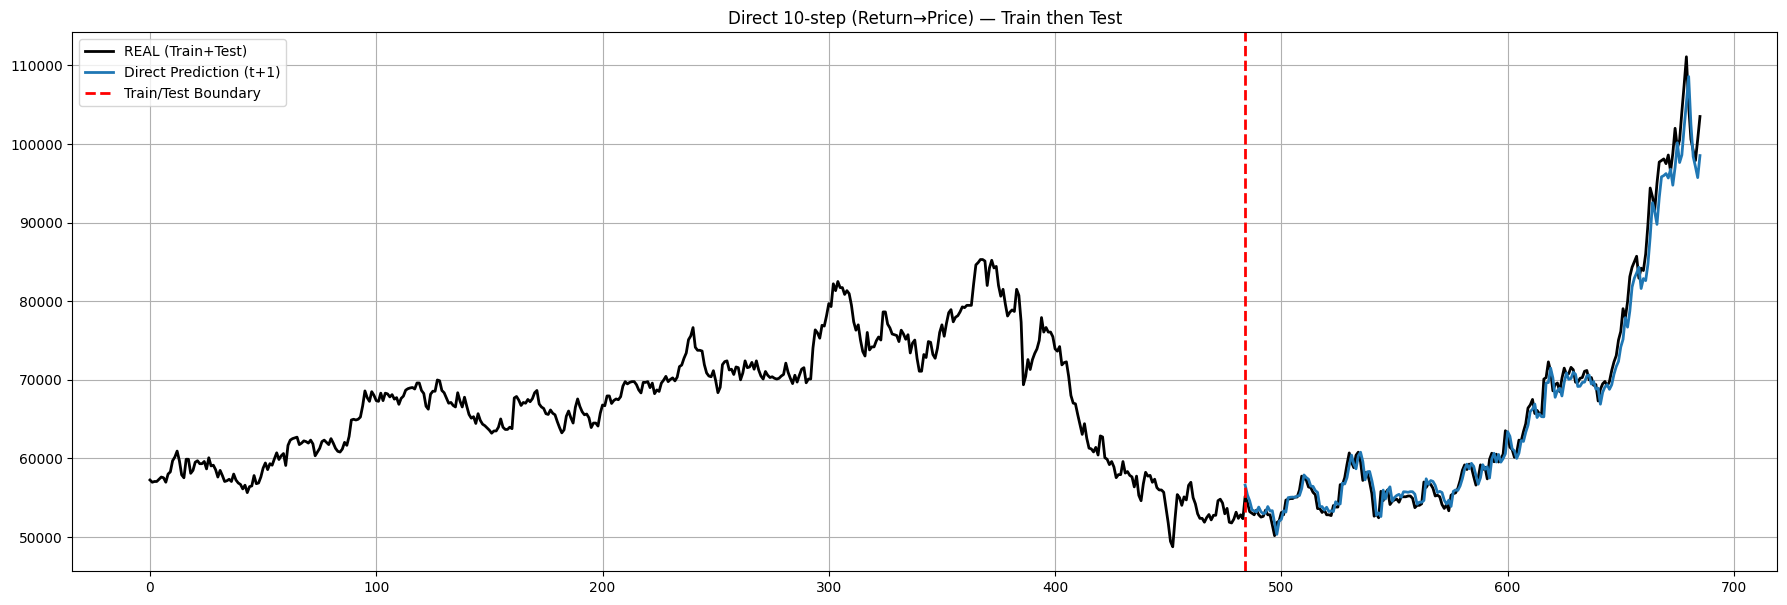

In [35]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

###########################################################
# 0) 데이터 다운로드
###########################################################
train_df = yf.download('005930.KS', start='2023-01-01', end='2024-12-31')
test_df  = yf.download('005930.KS', start='2025-01-01')

raw = train_df[['Close','Volume']].values.astype(np.float32)
test_raw = test_df[['Close','Volume']].values.astype(np.float32)

window_in = 5
window_out = 10

###########################################################
# 1) Dataset (Return target)
###########################################################
def make_dataset(data):
    X_enc, X_dec, Y_ret = [], [], []

    for i in range(len(data) - window_in - window_out):
        past   = data[i:i+window_in]
        future = data[i+window_in:i+window_in+window_out]

        # ---- Return 계산 ----
        future_close = future[:,0]
        ret = np.zeros(window_out, np.float32)
        ret[0] = (future_close[0] - past[-1,0]) / past[-1,0]
        ret[1:] = (future_close[1:] - future_close[:-1]) / future_close[:-1]

        SOS = np.array([[0.0,0.0]], np.float32)
        dec_in = np.concatenate([SOS, future[:-1]], axis=0)

        X_enc.append(past)
        X_dec.append(dec_in)
        Y_ret.append(ret)

    return np.array(X_enc), np.array(X_dec), np.array(Y_ret)

def make_dataset_direct(data):
    X_enc, X_dec, Y_ret = [], [], []
    for i in range(len(data) - window_in - window_out):
        past   = data[i:i+window_in]
        future = data[i+window_in:i+window_in+window_out]

        # Return
        ret = np.zeros(window_out)
        ret[0] = (future[0,0] - past[-1,0]) / past[-1,0]
        ret[1:] = (future[1:,0] - future[:-1,0]) / future[:-1,0]

        # Decoder 입력 = SOS only
        dec_in = np.array([[0.0, 0.0]], dtype=np.float32)

        X_enc.append(past)
        X_dec.append(dec_in)
        Y_ret.append(ret)

    return np.array(X_enc), np.array(X_dec), np.array(Y_ret)


X_enc, X_dec, Y_ret =make_dataset_direct(raw)
X_enc_test, X_dec_test, Y_ret_test =make_dataset_direct(test_raw)

###########################################################
# 2) Scaling (입력만)
###########################################################
close_min, close_max = raw[:,0].min(), raw[:,0].max()
vol_min,   vol_max   = raw[:,1].min(), raw[:,1].max()

def scale_inputs(x):
    x = x.copy()
    x[:,:,0] = (x[:,:,0] - close_min) / (close_max - close_min)
    x[:,:,1] = (x[:,:,1] - vol_min)   / (vol_max - vol_min)
    return x

X_enc_s  = scale_inputs(X_enc)
X_dec_s  = scale_inputs(X_dec)
X_enc_test_s = scale_inputs(X_enc_test)
X_dec_test_s = scale_inputs(X_dec_test)

###########################################################
# 3) Transformer 모델 (형이 가지고 있는 함수 사용)
###########################################################
model = transformer(
    vocab_size=1,
    num_layers=4,
    d_model=128,
    num_heads=4,
    dff=256,
    dropout=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss="mse"
)

###########################################################
# 4) 학습
###########################################################
history = model.fit(
    [X_enc_s, X_dec_s],
    Y_ret[...,None],
    batch_size=32,
    epochs=30,
    validation_split=0.1,
    verbose=1
)

###########################################################
# 5) Direct multi-step 예측  →  "10일 전체"
###########################################################
X_dec_direct = np.zeros((len(X_enc_test_s), 1, 2), dtype=np.float32)

# scaling
X_dec_direct_s = X_dec_direct.copy()
X_dec_direct_s[:,:,0] = (X_dec_direct[:,:,0] - close_min)/(close_max - close_min)
X_dec_direct_s[:,:,1] = (X_dec_direct[:,:,1] - vol_min)/(vol_max - vol_min)

# ---- Direct output: (M,10) 수익률 ----
pred_direct_ret = model.predict([X_enc_test_s, X_dec_direct_s])  # (M,10)


###########################################################
# 5-2) Direct 방식: 10일 전체 가격 복원
###########################################################
pred_direct_price = []
for i in range(len(pred_direct_ret)):
    last_price = X_enc_test[i, -1, 0]    # 실제 price (스케일 되지 않은 값)
    future_list = []
    for k in range(window_out):
        last_price = last_price * (1 + pred_direct_ret[i,k])
        future_list.append(last_price)
    pred_direct_price.append(future_list)

pred_direct_price = np.array(pred_direct_price)   # (M,10)


###########################################################
# 7) 실제 미래 10일 가격도 동일하게 생성
###########################################################
real_future_price = []
for i in range(len(X_enc_test)):
    real_future_price.append(
        test_raw[i+window_in : i+window_in+window_out, 0]
    )
real_future_price = np.array(real_future_price)   # (M,10)


###########################################################
# 8) Train + Test 이어붙여 시각화 (t+1만 표시)
###########################################################

# Train 실제 t+1
train_real = raw[window_in:, 0]

# Test 실제 t+1
test_real_t1 = real_future_price[:,0]

# Direct 예측 t+1
direct_t1 = pred_direct_price[:,0]

# boundary index
boundary = len(train_real)

# 전체 y 축
y_all = np.concatenate([train_real, test_real_t1])

# 예측 전체 배열
pred_direct_all = np.full_like(y_all, np.nan)
pred_direct_all[boundary:] = direct_t1

plt.figure(figsize=(22,7))
plt.plot(y_all, label="REAL (Train+Test)", color="black", linewidth=2)
plt.plot(pred_direct_all, label="Direct Prediction (t+1)", linewidth=2)

plt.axvline(boundary, color='red', linestyle='--', linewidth=2,
            label="Train/Test Boundary")

plt.title("Direct 10-step (Return→Price) — Train then Test")
plt.grid()
plt.legend()
plt.show()

